[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/065_transformer_decoder/transformer_decoder.ipynb)

# Transformer Decoder

En posts anteriores hemos aprendido e implementado la arquitectura *Transformer*, en particular el *Transformer Encoder* usado en multitud de aplicaciones. En el post anterior vimos como podemos usar este modelo para clasificar imágenes. Sin embargo, la arquitectura de *Transformer* original presentada en [*Attention is all you need*](https://arxiv.org/abs/1706.03762) incluye también un *Decoder*.

![](transformer.png)

En este post vamos a implementar esta arquitectura y aplicarla a la tarea de *image captioning*, generar texto a partir de imágenes.

## Dataset

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [2]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, max_len=8):
    self.X = X 
    self.y = y 
    self.max_len = max_len

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = torch.tensor(self.X[ix]).float().view(1, 28, 28)
    # añadimos `end of sentence` -> 2
    # usaremos 1 para `start of sentence`
    caption = torch.tensor([1] + self.y[ix] + [2]).long()
    # usamos 0 para pad
    caption = F.pad(caption, (0, self.max_len - len(caption)), 'constant', 0)
    return img, caption

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 1024):
        super().__init__()
        self.batch_size = batch_size
        self.vocab = 'abcdefghijklmnopqrstuvwxyz'
        self.len_vocab = len(self.vocab) + 3

    def number2caption(self, ix):
        if ix == 0: return 'cero'
        if ix == 1: return 'uno'
        if ix == 2: return 'dos'
        if ix == 3: return 'tres'
        if ix == 4: return 'cuatro'
        if ix == 5: return 'cinco'
        if ix == 6: return 'seis'
        if ix == 7: return 'siete'
        if ix == 8: return 'ocho'
        if ix == 9: return 'nueve'
        
    def caption2ixs(self, caption):
       return [self.vocab.index(c) + 3 for c in caption]

    def ixs2caption(self, ixs):
       return ('').join([self.vocab[ix - 3] for ix in ixs if ix not in [0, 1, 2]])

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"].astype(np.int)
        # convertimos etiquetas en palabras
        captions = [self.number2caption(ix) for ix in y]
        # cada letra tiene su número (índice en el vocab)
        encoded = [self.caption2ixs(caption) for caption in captions]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., encoded[:60000], encoded[60000:]
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, pin_memory=True)

In [3]:
dm = MNISTDataModule(batch_size=64)
dm.setup()
imgs, captions = next(iter(dm.train_dataloader()))
imgs.shape, captions.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 8]))

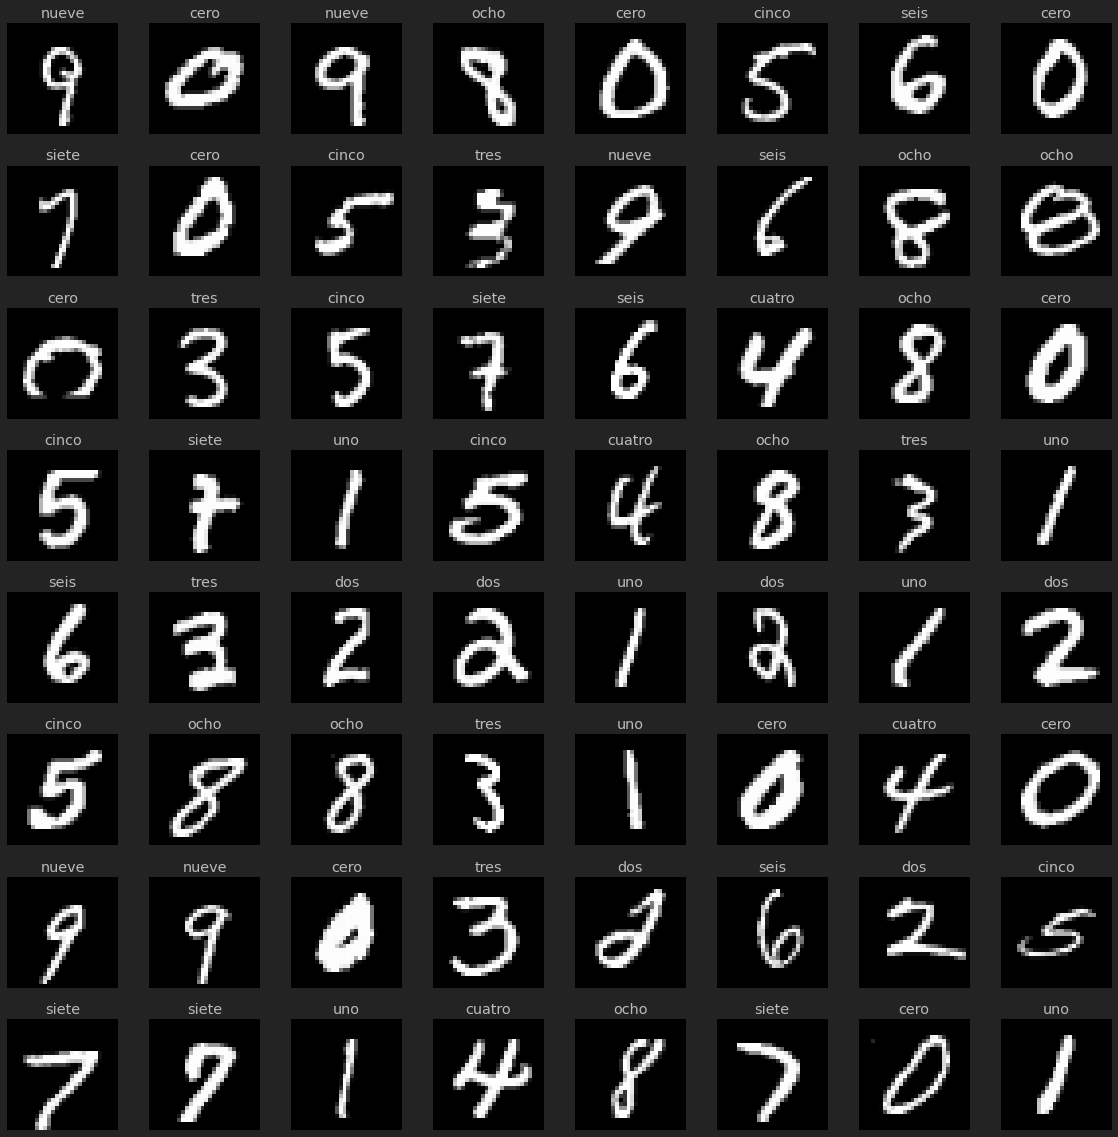

In [4]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        ax.set_title(label)
plt.tight_layout()
plt.show()

## El modelo

In [5]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [6]:
pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

In [7]:
import torch.nn.functional as F

class Model(pl.LightningModule):

    def __init__(self, 
                 len_vocab,
                 img_size=28, 
                 patch_size=7, 
                 in_chans=1, 
                 embed_dim=100, 
                 max_len=8, 
                 nhead=2, 
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                ):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        
        self.trg_emb = nn.Embedding(len_vocab, embed_dim)
        self.trg_pos_emb = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len

        self.transformer = torch.nn.Transformer(
            embed_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout
        )
        
        self.l = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, len_vocab)

    def forward(self, images, captions):
        # embed images
        embed_imgs = self.patch_embed(images)
        embed_imgs = embed_imgs + self.pos_embed  # (B, N, E)
        # embed captions
        B, trg_seq_len = captions.shape 
        trg_positions = (torch.arange(0, trg_seq_len).expand(B, trg_seq_len).to(self.device))
        embed_trg = self.trg_emb(captions) + self.trg_pos_emb(trg_positions)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(self.device)
        tgt_padding_mask = captions == 0
        # transformer
        y = self.transformer(
            embed_imgs.permute(1,0,2),  # S, B, E
            embed_trg.permute(1,0,2),  # T, B, E
            tgt_mask=trg_mask, # T, T
            tgt_key_padding_mask = tgt_padding_mask
        ).permute(1,0,2) # B, T, E
        # head
        return self.fc(self.l(y))

    def predict(self, images):
        self.eval()
        with torch.no_grad():
            images = images.to(self.device)
            B = images.shape[0]
            # start of sentence
            eos = torch.tensor([1], dtype=torch.long, device=self.device).expand(B, 1)
            trg_input = eos
            #while True:
            for _ in range(self.max_len):
                preds = self(images, trg_input)
                preds = torch.argmax(preds, axis=2)
                trg_input = torch.cat([eos, preds], 1)
                #if torch.any(captions == 2, 1).sum().item() == B or captions.shape[1] >= model.max_len:
                #    return preds
            return preds
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x, y[:,:-1])
        trg_output = y[:,1:] # target sin EOS token
        # [ Batch, seq len, num features ] --> [ Batch, num features, seq len ]
        loss = F.cross_entropy(y_hat.permute(0,2,1), trg_output) 
        acc = (torch.argmax(y_hat, axis=2) == trg_output).sum().item() / (trg_output.shape[0]*trg_output.shape[1])
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [8]:
model = Model(dm.len_vocab)
out = model(imgs, captions)
out.shape

torch.Size([64, 8, 29])

In [9]:
dm = MNISTDataModule()
model = Model(dm.len_vocab)
trainer = pl.Trainer(max_epochs=10, gpus=1, precision=16)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name        | Type           | Params
-----------------------------------------------
0 | patch_embed | PatchEmbedding | 5 K   
1 | trg_emb     | Embedding      | 2 K   
2 | trg_pos_emb | Embedding      | 800   
3 | transformer | Transformer    | 850 K 
4 | l           | LayerNorm      | 200   
5 | fc          | Linear         | 2 K   
/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [10]:
imgs, captions = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

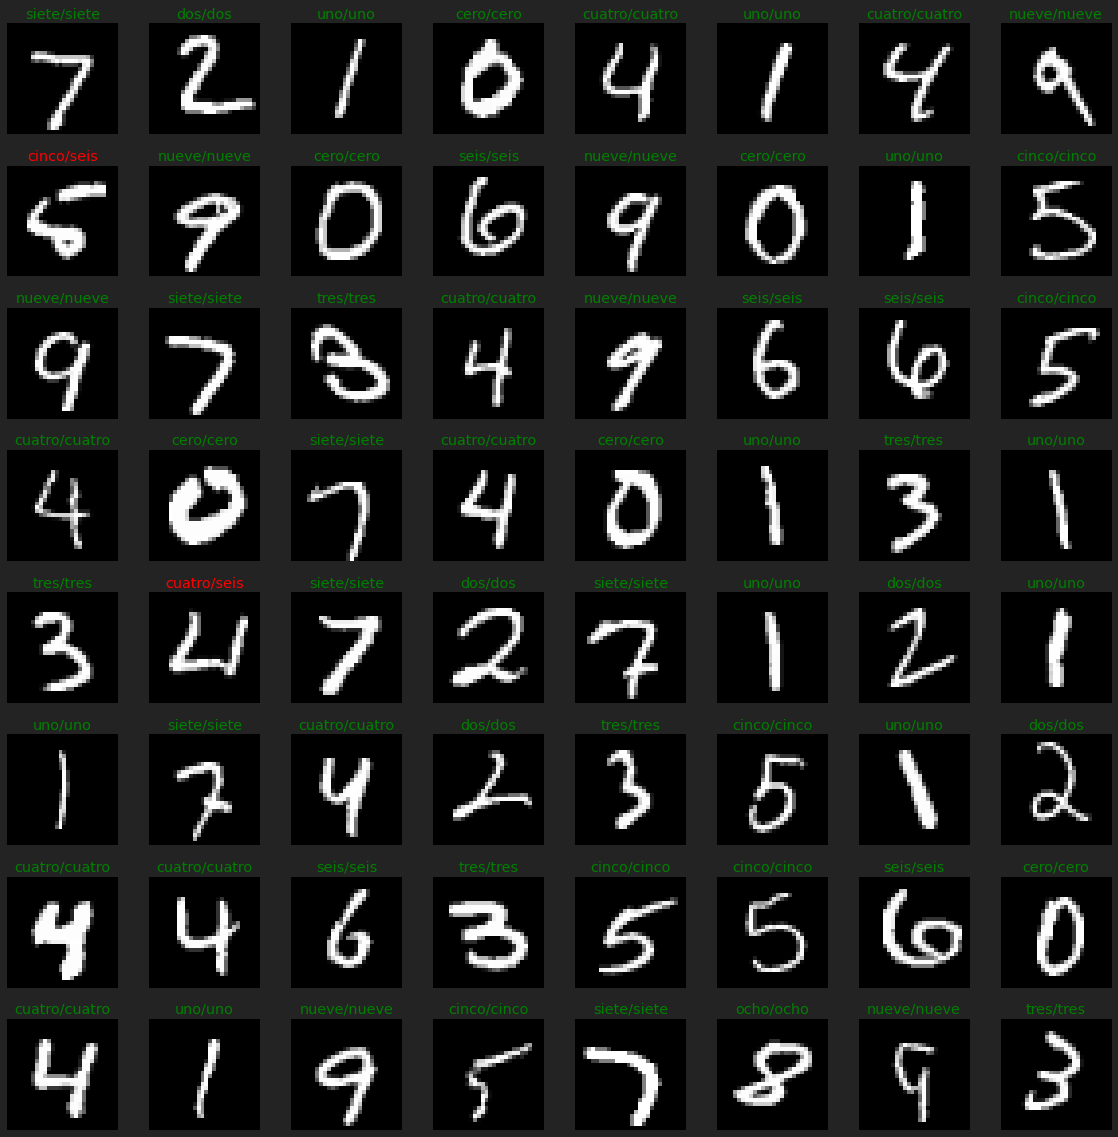

In [11]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        pred = dm.ixs2caption(preds[ix])
        ax.set_title(label)
        ax.set_title(f'{label}/{pred}', color="green" if label == pred else 'red')
plt.tight_layout()
plt.show()

## Resumen

Hemos visto como mejorar el mecanismo de atención añadiendo varias cabezas a las cuales atender en paralelo. De esta forma, la capacidad para representar datos de nuestro modelo se ve incrementada. 